### Introduction

Calculating the potential density anomaly of seawater, considering variables such as salinity, temperature, and pressure, is a complex task. The latest standard in oceanography, TEOS-10, facilitates this computation through an efficient 75-term polynomial expression developed by Roquet et al. (2015). This approach uses absolute salinity and conservative temperature to accurately determine the potential density anomaly (ptential density - 1000 kg/m^3).

Recently, Kolmogorov-Arnold Network (KAN) has been proposed to achieve good results in finding symbolic functions behind scientific data. Here, I tried creating a KAN network to obtain much simpler formula  while still maintaining the reasonable accuracy of the computation of potential density anomaly.

Reference:

1. Roquet, F., Madec, G., McDougall, T. J., & Barker, P. M. (2015). Accurate polynomial expressions for the density and specific volume of seawater using the TEOS-10 standard. Ocean Modelling, 90, 29-43.

2. TEOS-10 gsw_sigma0 function: https://www.teos-10.org/pubs/gsw/html/gsw_sigma0.html

3. Liu, Z., Wang, Y., Vaidya, S., Ruehle, F., Halverson, J., Soljačić, M., ... & Tegmark, M. (2024). Kan: Kolmogorov-arnold networks. arXiv preprint arXiv:2404.19756.

### Step 1: Creating training dataset
To obtain the dataset of absolute salinity (SA), conservatrive temperature (CT) and potential density anomaly, data are downloaded from World Ocean Atlas 2018. SA and CT were computed in ODV software based on the TEOS-10 standards (https://www.teos-10.org/pubs/gsw/html/gsw_sigma0.html).  

In [1]:
from kan import *

from pandas import read_csv

column_names = ['CTDPRS', 'Temperature', 'Salinity', 'SA', 'CT','density']
data = read_csv('./WOASA.csv', header=0)

data = data.sample(frac=1).reset_index(drop=True)
x = data.loc[:,column_names]
import pandas as pd
x = pd.DataFrame(data=x, columns=column_names)
print(x)

         CTDPRS  Temperature  Salinity      SA    CT  density
0          2128         2.32    34.715  34.885  2.16   27.735
1          1872         2.65    34.643  34.812  2.51   27.648
2          1976         2.34    34.644  34.814  2.20   27.677
3            20         8.94    34.343  34.505  8.94   26.616
4          3561         0.50    34.695  34.868  0.25   27.855
...         ...          ...       ...     ...   ...      ...
1031815     277         0.87    34.687  34.858  0.86   27.810
1031816    2741         1.75    34.709  34.881  1.55   27.780
1031817    1925         2.35    34.618  34.788  2.21   27.655
1031818    3762         1.12    34.720  34.892  0.84   27.838
1031819     505         2.16    34.612  34.782  2.13   27.656

[1031820 rows x 6 columns]


In [5]:
column_xtrain = ['SA', 'CT']
column_ytrain = ["density"]

In [24]:
# the original dataset has 1031820 entries, here we only select 18000 (1%) entries for train and test datasets
x_train = x.loc[0:18000,column_xtrain]
y_train = x.loc[0:18000,column_ytrain ]
x_test = x.loc[18000:22000,column_xtrain]
y_test = x.loc[18000:22000,column_ytrain ]

dataset = {}
dataset['train_input'] = torch.from_numpy(x_train.values).float()
dataset['test_input'] = torch.from_numpy(x_test.values).float()

dataset['train_label'] = torch.from_numpy(y_train.values).float() 
dataset['test_label'] = torch.from_numpy(y_test.values).float()

### Step 2: Creating a KAN Network

In [25]:
# create a KAN: 2D inputs, 1D output, and 1 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).

model = KAN(width=[2,1,1], grid=5, k=3, seed=42)

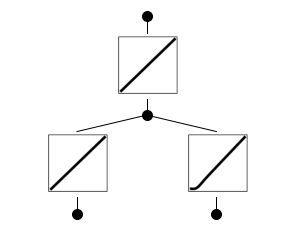

In [26]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [29]:
#train the model
model.train(dataset, opt="LBFGS", steps=20,lr=1e-2);

train loss: 1.73e-02 | test loss: 1.73e-02 | reg: 2.18e+01 : 100%|██| 20/20 [00:14<00:00,  1.37it/s]


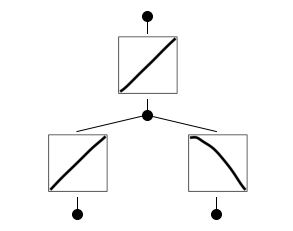

In [30]:
# visualize the model
model.plot(beta=100)

### Step 3: Finding symbolic formula to compute potential density anomaly from SA and CT

Note that (0,0,0) is like a "x" function, (0,0,1) is like a x^2 function, and (1,0,0) is like a "x" function 

In [31]:
model.fix_symbolic(0,0,0,'x')
model.train(dataset, opt="LBFGS", steps=20);

r2 is 0.9991711974143982


train loss: 1.57e-02 | test loss: 1.57e-02 | reg: 2.19e+01 : 100%|██| 20/20 [00:09<00:00,  2.17it/s]


In [32]:
model.fix_symbolic(0,1,0,'x^2')
model.train(dataset, opt="LBFGS", steps=20);

r2 is 0.9996784329414368


train loss: 5.68e-03 | test loss: 5.68e-03 | reg: 2.18e+01 : 100%|██| 20/20 [00:02<00:00,  7.39it/s]


In [33]:
model.fix_symbolic(1,0,0,'x')
model.train(dataset, opt="LBFGS", steps=20);

r2 is 0.9998708367347717


train loss: 1.06e-02 | test loss: 1.06e-02 | reg: 2.18e+01 : 100%|██| 20/20 [00:03<00:00,  6.43it/s]


In [83]:
# continue to train the model
model.train(dataset, opt="LBFGS", steps=50);


train loss: 5.42e-03 | test loss: 5.63e-03 | reg: 2.20e+01 : 100%|██| 50/50 [00:04<00:00, 11.08it/s]


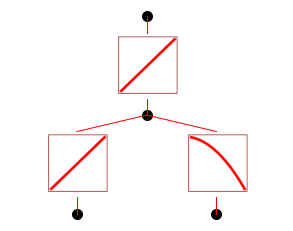

In [13]:
# visualize the model
model.plot(beta=100)

In [34]:
# get symbolic_formula
model.symbolic_formula()[0][0]

0.79*x_1 - 0.13*(-0.21*x_2 - 1)**2 + 0.54

In [53]:

# I run the KAN network several times and I find the coefficients below can archieve a best result
simple_model_rho = 0.79 * data["SA"] - 0.13 * (0.21 * data["CT"] + 1) ** 2 + 0.445

C:\Users\Zhou\AppData\Local\Temp\ipykernel_14224\694772121.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  slope = np.linalg.lstsq(simple_model_rho[:, np.newaxis], data["density"], rcond=None)[0][0]


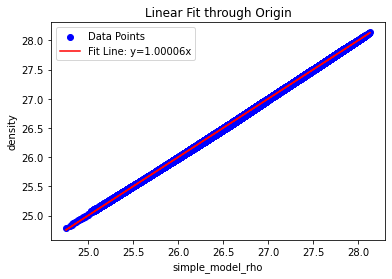

In [93]:
import matplotlib.pyplot as plt
# Performing linear regression
# Performing linear regression with a forced intercept at zero
slope = np.linalg.lstsq(simple_model_rho[:, np.newaxis], data["density"], rcond=None)[0][0]
line = slope * simple_model_rho

# Creating the scatter plot
plt.scatter(simple_model_rho, data["density"], color='blue', label='Data Points')

# Plotting the linear fit line
plt.plot(simple_model_rho, line, color='red', label=f'Fit Line: y={slope:.5f}x')

# Adding title and labels
plt.title('Linear Fit through Origin')
plt.xlabel('simple_model_rho')
plt.ylabel('density')
plt.legend()

# Showing the plot
plt.show()

In [94]:
# calculate RMSE

import math  
import sklearn.metrics  

mse = sklearn.metrics.mean_squared_error(data["density"],simple_model_rho)  
  
rmse = math.sqrt(mse)  
print("The difference between actual and predicted values", rmse)  

# Calculate the mean of the actual values
mean_actual = np.mean(data["density"])

# Calculate Normalized Root Mean Squared Error (NRMSE) as a percentage
nrmse_percentage = (rmse / mean_actual) * 100
print("Relative Root Mean Squared Error:", nrmse_percentage, "%")

The difference between actual and predicted values 0.008389372521355546
Relative Root Mean Squared Error: 0.030587360049704627 %


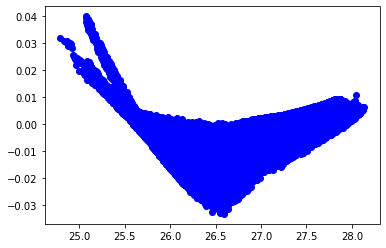

In [95]:
# take a look on the error distribution vs potential density anomaly
plt.scatter( data["density"], data["density"]-simple_model_rho,color='blue', label='Data Points')
plt.show()

In [96]:
# compare gloabl mean 
mean_SA = data["SA"].mean()
mean_CT = data["CT"].mean()

print(mean_SA)

print(mean_CT)


34.68393343606443
2.880657566242175


In [97]:
0.79 * mean_SA - 0.13 * (0.21 * mean_CT+ 1) ** 2 + 0.445

27.510449999490113

In [98]:
import gsw
gsw.density.sigma0(mean_SA, mean_CT)


27.514075143652235

### Evaluation by using a real CTD profile 

In [99]:
test_data = read_csv('./SAtest.csv', header=0)

In [100]:
rho_test = gsw.sigma0(test_data['SA'],test_data['CT'])
rho_test_simple = 0.79 * test_data['SA'] - 0.13 * (0.21 * test_data['CT']+ 1) ** 2 + 0.445

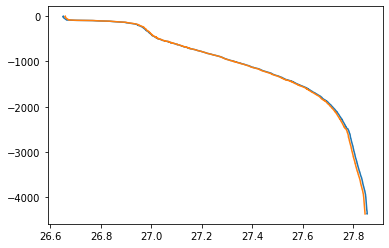

In [101]:
plt.plot(rho_test,-test_data['CTDPRS'])
plt.plot(rho_test_simple,-test_data['CTDPRS'])


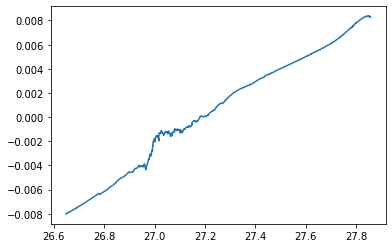

In [102]:
plt.plot(rho_test,rho_test-rho_test_simple)